# <span style="color:darkslateblue"> Meccanica Statistica 1 </span>
## <span style="color:darkcyan">  Exercise 5 on the SIR Model. Samuele Voltan's notebook.</span>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from typing import List
from collections import Counter
from scipy.integrate import solve_ivp

import sys
sys.path.append("code/")
from graph_SIR import GraphSIR

We will focus on the SIR model, probably the most studied model in computational epidemics. In its simplest form, the SIR model can be defined as follows. A large population of $N$ individuals is divided into three classes:
+ **Susceptible** individuals (S): those who do not have the disease but can get it.
+ **Infected** individuals (I) : those who have the disease.
+ **Recovered** individuals (R): those who cannot get the disease anymore.

The basic dynamics of the model are simple as well:
1. Susceptible individuals might get infected if they are in contact with an infected individual. 
2. Infected individuals become recovered after some time. 

Notice that individuals can only go from *S* to *I* and from *I* to *R*. We will also assume that infective individuals have contacts with randomly chosen individuals of all states at an average rate $\beta$ per unit time, and recover and acquire immunity (or die) at an average rate $\gamma$ per unit time. 


### <span style="color:darkslateblue">Fully mixed population.
If we assume a very large population that is **fully mixed**, then the model can be descrived by a set of coupled nonlinear differential equations:  


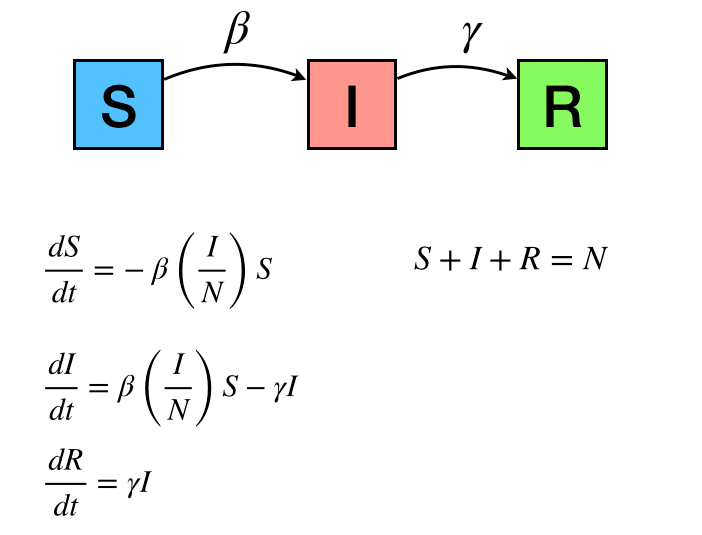 

### <span style="color:darkcyan"> Exercise 5.1
We define a function `ode_SIR` that represents the system of differential equations of a SIR model and follows the specification of `solve_ivp`.

In [2]:
def odes_SIR(t, y) :
    S, I, R = y
    N = S + I + R
    f = np.array([
        - beta * I * S / N,
        beta * I * S / N - I * gamma,
        I * gamma,        
    ])
    return f

### <span style="color:darkcyan"> Exercise 5.2
If we define

$$
R(t) = \frac{\beta}{\gamma N}S(t),
$$

then the number of infected individuals decreases if $R(t)<1$. Below we study the behavior of the infection for different values of $R(0)=R_0$.

In [3]:
# set parameters
n = 1000
s = 990
R0s = [1, 2, 5, 100]
y0 = (s, n-s, 0)
tmax = 10**4

# solve ODE
ode_results = []
for R0 in R0s :
    beta = 0.5
    gamma = beta * s / (R0 * n)
    ode_results += [solve_ivp(odes_SIR, (0, tmax), y0)]

# extract results
t_ranges = []
for res in ode_results:
    assert res.success
    t_ranges += [res.t]

Below we show our results in four different plots. Note that we used the logarithmic scale for the time axis in order to have smooth transitions in the early stages of the simulation

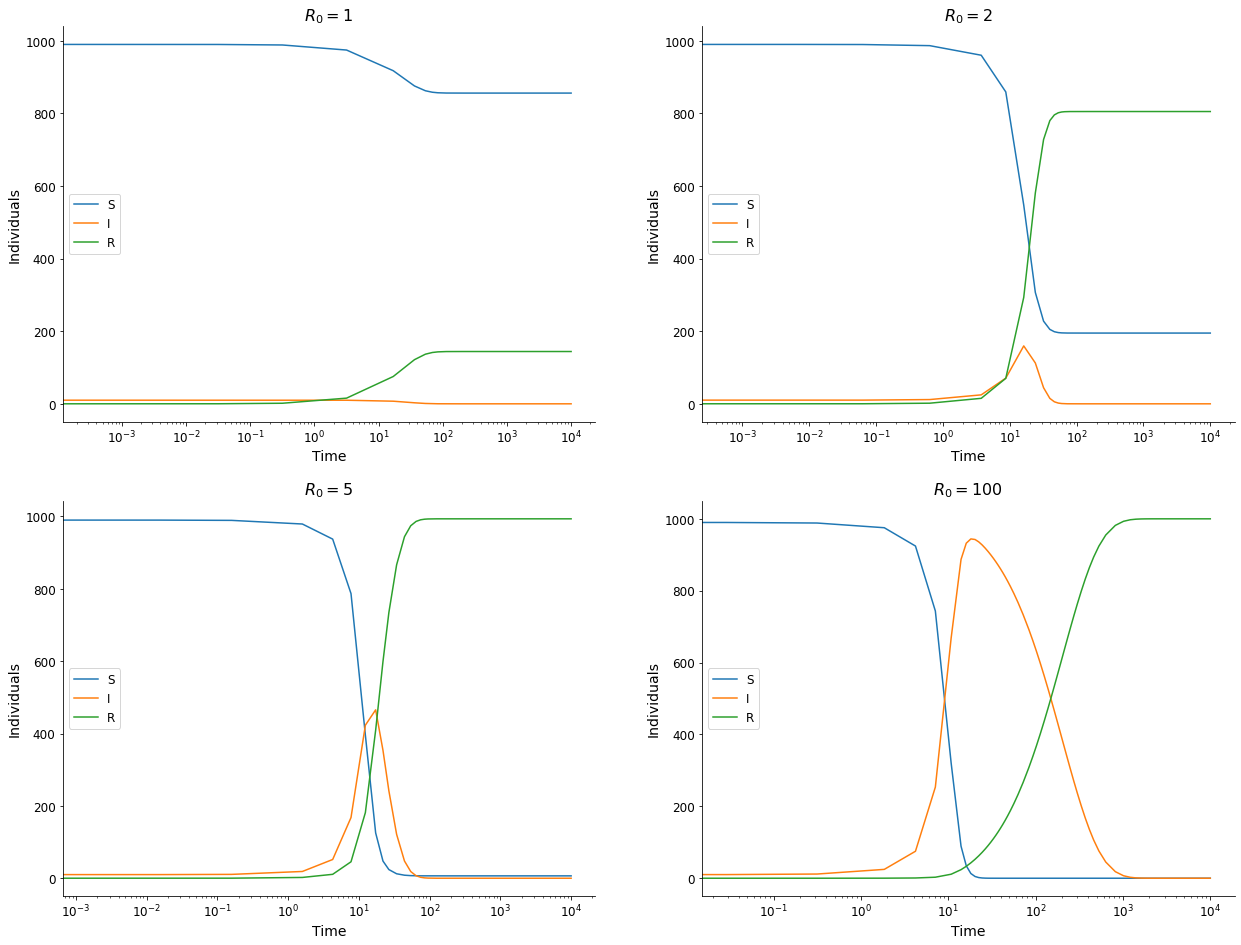

In [4]:
fig, axs = plt.subplots(2, 2, figsize = (21, 16))
for ax, t_range, R0, res in zip(axs.flat, t_ranges, R0s, ode_results) :
    S, I, R = res.y
    beta = 0.5
    gamma = beta / R0
    ax.semilogx(t_range, S, label = 'S')
    ax.semilogx(t_range, I, label = 'I')
    ax.semilogx(t_range, R, label = 'R')
    ax.set_xlabel('Time')
    ax.set_ylabel('Individuals') 
    ax.set_title(r'$R_0= $' + str(R0))
    ax.legend(loc = 'center left')

Our results provide a numerical proof of the fact that the infection fails to spread to every individual if $R_0\sim 1$. Of course, one could argue that we started with a rate $S(0)/N\sim 1$, since only 10 over 1000 individuals were infected at the beginning. This is another parameter that one must take into account, but it is strictly related to $R_0$ and therefore, by changing our initial settings, we would only be changing the infection and recovery rate $\beta$ and $\gamma$.

### <span style="color:darkslateblue"> SIR model on a network.
The ODE approximation of the SIR model is not very realistic because it assumes a fully mixed population.
The fact that we do not interact randomly with one another, but rather have complex social structures, schools, commuting etc is what makes the whole thing much more difficult.

To explore the importance of the contact network for the spread of a disease, we will implement a simple discrete-time SIR model that runs on an arbitrary network or graph. To do so, we will define a class `GraphSIR` that holds together the graph where the SIR model runs and the methods that implement the SIR dynamics. We will use the `networkx` module.

Let us try it. First we need to create a graph! Networkx has some functions to generate standard graphs. We could start with a lattice graph, for instance.

### <span style="color:darkcyan"> Exercise 5.3
The file `code/graph_SIR.py` contains a class, `GraphSIR` that is the SIR model on a lattice. In this exercise, we define its constructor, that takes the following inputs:
  
1. The graph onto which we want to run the SIR model.
2. A list of initially infected nodes.
3. The coefficient $\beta$
4. The coefficient $\gamma$
    
A few things more that `__init__` must do are:
    
1. Checking that $\beta$ and $\gamma$ have sensible values.
2. Making sure that all elements in input list of inital infected are really nodes of the network.
2. Creating a node attribute called "kind" with value "S" for all nodes except for those in the list of `inital_infected`

### <span style="color:darkcyan"> Exercise 5.4
Using [the networkx documentation](https://networkx.org/documentation/stable/reference/drawing.html) we define a method for the class `GraphSIR` to visualize a hexagonal lattice model, with nodes colored by type.

Below, we check if it works properly.

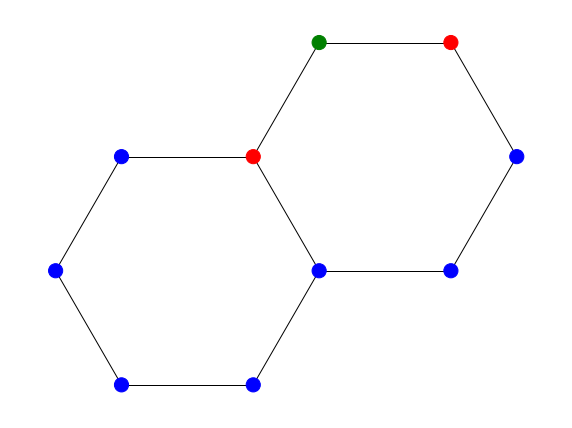

In [5]:
G = nx.hexagonal_lattice_graph(1,2)
test_show = GraphSIR(network=G, initial_infected=[(1,2),(2,3)], beta=0.3, gamma=0.1)
test_show.network.nodes[(1,3)]['kind'] = 'R'
test_show.show();

### <span style="color:darkcyan"> Exercise 5.5
We implement the discrete-time dynamics of the SIR model as methods of `GraphSIR` class as follows:

+ Infected individuals have a chance to recover, and they do so with probability $\gamma$.
+ Susceptible individuals can be infected by any of the infected individuals to which they are connected. This happens with probability $\beta$ for each S-I edge.

In order to do so, we define two separate methods:

+ `_step(self)`: this method implements one single time-step, as descrived above.
+ `run(self, num_timesteps: int)`: this method (for now) simply calls `_step` repeatedly.

### <span style="color:darkcyan"> Exercise 5.6
We show the evolution of a SIR model running in a hex lattice.

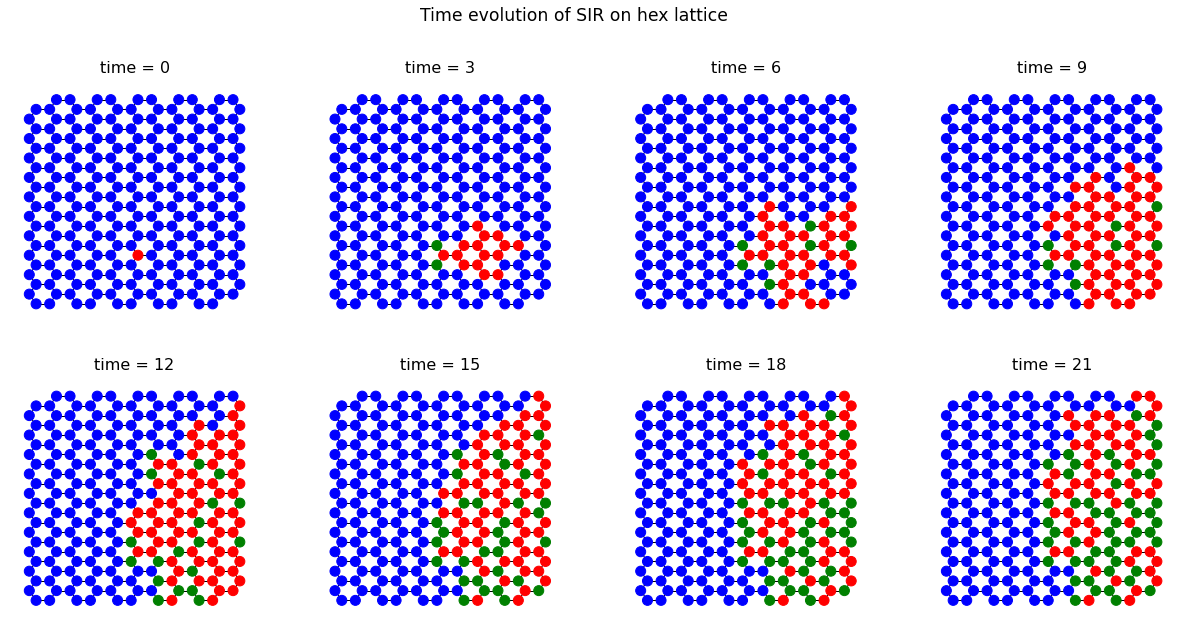

In [6]:
# create the model
test_evolution_lattice = nx.hexagonal_lattice_graph(10, 10)
test_evolution = GraphSIR(
    network=test_evolution_lattice,
    initial_infected=[(5, 5)],
    beta=0.3,
    gamma=0.05)
timestep = 3
steps = [timestep*n for n in range(8)]

# display its evolution
fig, axx = plt.subplots(2, 4, figsize=(21, 10))
axx = axx.reshape(-1)
fig.suptitle('Time evolution of SIR on hex lattice', fontsize = 'xx-large')
for n, ax in zip(steps, axx) :
    ax.set_title('time = ' + str(n))
    test_evolution.show(ax=ax, node_size=100)
    test_evolution.run(timestep)

### <span style="color:darkcyan"> Exercise 5.7
For now, our class can run the SIR dynamics, but it doesn't remember the whole evolution of the simulation: only the final state is available. We modify the class so that it stores the number of **S**, **I** and **R** individuals at each timestep, by the following steps:

+ Create an empty list at initialization `self.history = []`.
+ Create a `_log()` method that, when called, computes the information we want to store and adds it to the `self.history` list.

We then simulate the SIR model.

In [7]:
def SIR_dynamics(model, time_steps, plot=True) :
    """
    SIR DYNAMICS:
    Runs the SIR on graph for some time, then plots number of I, S and R against time.
    #
    run the model for some time
    #
    extract evolution of S, I, R from model.history
    #
    plot S, I and R with time
    #
    return fig, ax
    """
    model.run(time_steps)
    #
    evS, evI, evR = [], [], []
    for info in model.history:
        evS.append(info[0])
        evI.append(info[1])
        evR.append(info[2])
    #
    if plot :
        fig, ax = plt.subplots(1,1, figsize=(10,7))
        ax.plot(evS, label = r'S')
        ax.plot(evI, label = r'I')
        ax.plot(evR, label = r'R')
        ax.set_xlabel(r'Time')
        ax.set_ylabel(r'Individuals') 
        ax.set_title(r'SIR Model on a network with $\beta= $' + str(model.beta) + r', $\gamma=$' + str(model.gamma))
        ax.legend(loc='best');
    #
    return evS, evI, evR

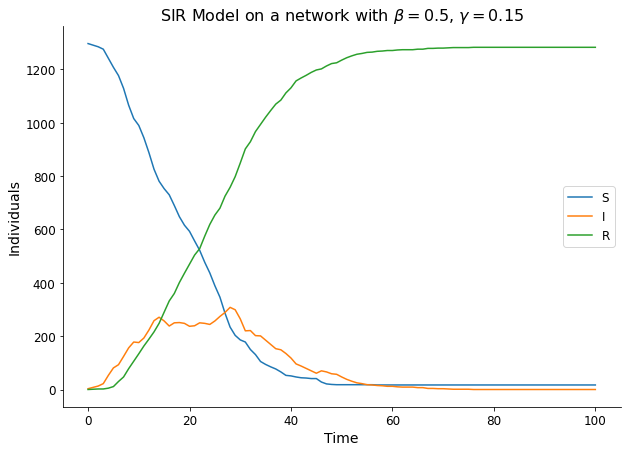

In [8]:
# create the model
test_log = GraphSIR(
    network=nx.hexagonal_lattice_graph(30, 20),
    initial_infected=[(10, 10), (2, 2), (2, 5)],
    beta=0.5,
    gamma=0.15
)

SIR_dynamics(test_log, 100);

### <span style="color:darkcyan">Exercise 5.8
Which kind of network could give results equivalent to the ODE solution of the first part of the notebook? Explain why.

Since the ODE approach main hypothesis was the fact that everybody could interact with each other member of the population, a fully connected graph should reproduce the ODE result. A fully connected graph with $N$ point all connected to each other has

$$
(N-1) + (N-2) + \dots + 1 = \frac{N(N-1)}2.
$$

edges.

### <span style="color:darkcyan">Exercise 5.9
With help from the [Erdős-Rényi algorithm](https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.gnp_random_graph.html#r8f60952a7cee-2) implemented by `networkx.gnp_random_graph()`, we create a random fully connected graph.

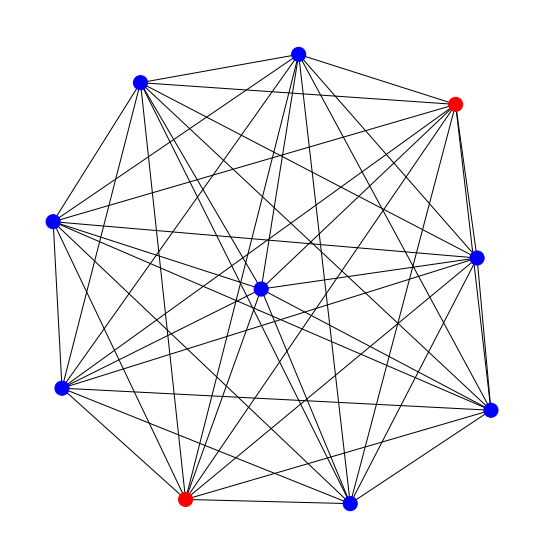

In [9]:
n_points = 10
prob_edges = 1
test_gnp = GraphSIR(
    network=nx.gnp_random_graph(n_points, prob_edges, seed=None, directed=False),
    beta=0.3,
    gamma=0.05,
    initial_infected=[3,9]
)
test_gnp.show(with_pos=False);

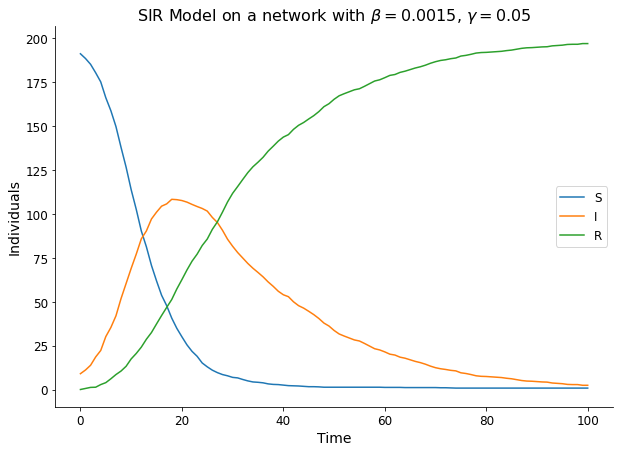

In [10]:
# parameters definition
n_points = 200
prob_edge = 1
prob_infected = 0.025
beta = 0.0015
gamma = 0.05
num_sim = 10

# randomly select initial infected with prob = prob_infected
initial_infected = []
for i in range(n_points) :
    p = np.random.uniform()
    if p < prob_infected :
        initial_infected.append(i)
        
# run the simulations and accumulate values for S, I and R
evS, evI, evR = [], [], []
for _ in range(num_sim) :
    
    # create model (with same initial_infected)
    mean_network_evolution = GraphSIR(
        network=nx.gnp_random_graph(n_points, prob_edge, seed=None, directed=False),
        beta=beta,
        gamma=gamma,
        initial_infected=initial_infected
    )
    
    # evolve and get S, I and R
    S, I, R = SIR_dynamics(mean_network_evolution, 100, plot=False)
    
    # append values to global S, I and R
    evS.append(S)
    evI.append(I) 
    evR.append(R)
    
# take mean values
meanS = np.mean(evS, 0)
meanI = np.mean(evI, 0)
meanR = np.mean(evR, 0)

# display results
fig, ax = plt.subplots(1,1, figsize=(10,7))
ax.plot(meanS, label = r'S')
ax.plot(meanI, label = r'I')
ax.plot(meanR, label = r'R')
ax.set_xlabel(r'Time')
ax.set_ylabel(r'Individuals') 
ax.set_title(r'SIR Model on a network with $\beta= $' + str(beta) + r', $\gamma=$' + str(gamma))
ax.legend(loc='best');

In [11]:
meanS.size

101

15

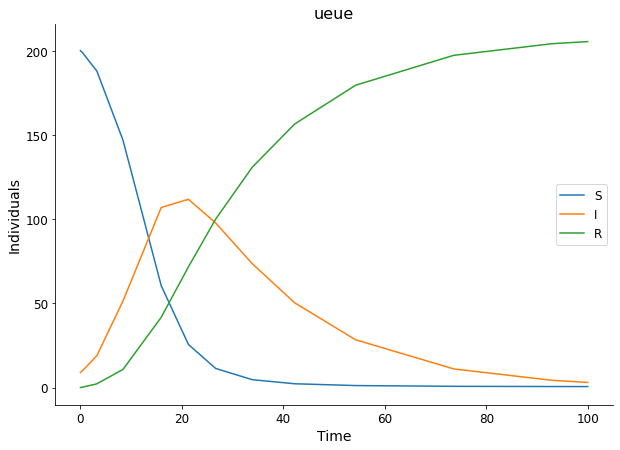

In [12]:
# parameters definition
n_points = 200
prob_edge = 1
prob_infected = 0.025
beta = 0.3
gamma = 0.05
num_sim = 10

y0 = (meanS[0]+meanI[0]+meanR[0], meanI[0], 0)
res = solve_ivp(odes_SIR, (0, 100), y0)
fig, ax = plt.subplots(1,1, figsize=(10,7))

S, I, R = res.y
t_range = res.t
ax.plot(t_range, S, label = 'S')
ax.plot(t_range, I, label = 'I')
ax.plot(t_range, R, label = 'R')
ax.set_xlabel('Time')
ax.set_ylabel('Individuals') 
ax.set_title(r'ueue')
ax.legend(loc = 'best')

S.size

*Your reasoning about why we still see differences herer*

### <span style="color:darkslateblue"> The spread of epidemic disease on networks.
We will now follow some of the derivations in 

*Spread of epidemic disease on networks.*  
Newman, M.E.J. (2002).  
Phys. Rev. E Stat. Nonlin. Soft Matter Phys. 66, 016128.

### <span style="color:darkcyan">Exercise 5.10
Read the first part of the [paper](https://arxiv.org/abs/cond-mat/0205009). Under which assumptions is the Eq. 6 valid? What is the meaning of $r$ and $\tau$ in the manuscript? Can you relate $P(r)$ and $P(\tau)$ to our coefficients $\beta$ and $\gamma$?

The author defines $r_{ij}$ as the average rate of disease-causing contacts beween the $r$-th and the $j$-th individual, and $\tau_i$ as the time that the $i$-th individual takes to recover. Both variables are assumed to be i.i.d. variables sampled from the probability distributions $P(r)$ and $P(\tau)$. Under these assumptions, the following equation holds:

$$
T =  1 - \int_0^\infty dr \sum_{\tau=0}^{\infty} P(r) P(\tau) (1-r)^\tau,
$$

$T$ being the transmissibility, i.e. the average probability that a victim will infect each of their contacts. In this picture, $\beta$ and $\gamma$ represent ... 


NOT the means of the distributions $P(r)$ and $P(\tau)$.

### <span style="color:darkcyan">Exercise 5.11
Compute the transmissiblity $T$ of our discrete-time SIR model in terms of $\beta$ and $\gamma$ using Newman's calculation (but bear in mind that this result is valid only under the assumptions of the paper).

$$
T = 1-\gamma\sum_{\tau=0}^\infty(1-\beta)^\tau(1-\gamma)^{\tau-1} = 1-\frac{\gamma}{1-\gamma}\frac{1}{1-(1-\beta)(1-\gamma)}
$$

### <span style="color:darkcyan">Exercise 5.12
We add a few lines to `__init__` that compute the transmissibility. A check here is rather trivial: we set $\beta = 0.375$ and $\gamma = 0.2$, and we should get $T=1/2$.

In [2]:
# create the model
test_transm_lattice = nx.hexagonal_lattice_graph(2, 2)
test_transm = GraphSIR(
    network=test_transm_lattice,
    initial_infected=[(1, 1)],
    beta=0.375,
    gamma=0.2)

# check (should be 2T = 1)
assert(test_transm.T * 2 == 1)

### <span style="color:darkslateblue"> The critical transmissibility $T_c$.
The critical transmissibility $T_c$ can be defined as the value below which the system displays small outbreaks, and above which we have a global pandemic that spans the whole system. We will now try to see, numerically, that indeed there is a phase transition, and will compare our estimates of $T_c$ with some theoretical calculations from the literature. Notice that Newman explains in the manuscript that the SIR model on a network is equivalent to **bond percolation** with occupation probability $T$. Do you see why? Let us read Newman again:

Therefore, Newman *maps* the SIR-on-a-network problem to a known statistical mechanics problem, and all known result on the later can be translated to the former straightforwardly.

### <span style="color:darkcyan">Exercise 5.13
To study the total size of an epidemic, defined as the total number of individuals ever infected, simulations that run for a pre-fixed number of steps are not very useful, since some outbreaks might take much longer than others to extinguish. Therefore, we add a new method to our class called `_getSize(self)` that runs a simulation until no more infected individuals are left and returns the size of the epidemic, meaning the final number of recovered individuals.
    
Below we test the function. As expected, the network status shows no individual infected.

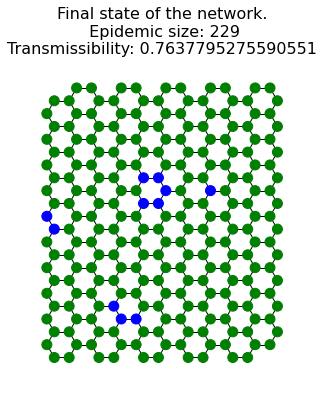

In [3]:
# create the model
test_getSize_lattice = nx.hexagonal_lattice_graph(10, 10)
test_getSize = GraphSIR(
    network=test_getSize_lattice,
    initial_infected=[(5, 5)],
    beta=0.1,
    gamma=0.03)

# run the model until outbreak is estinguished
size = test_getSize._getSize()
trans = test_getSize.T

# display final state of the network
fig, ax = plt.subplots(1, 1, figsize=(5, 6))
ax.set_title('Final state of the network.\n Epidemic size: ' + str(size) + '\nTransmissibility: ' + str(trans))
test_getSize.show(ax=ax, node_size=100)

As expected, the network status shows no individual infected and a hight transmissibility, since the size of the model is almost the number of total individuals.

### <span style="color:darkslateblue"> Generating realistic networks.
To reproduce Figure 1 of Newmann's paper, we need to generate networks with the distrirbution of Equation (30). Using the `nx.configuration_model` function, we can generate a network with an arbitrary degree sequence. We rely on the following functions.

In [2]:
def p_of_k(k, alpha, kappa):
    """
    Power-law of exponent alpha and exponential cutoff at kappa, 
    as defined in Newman, 2002. Equation 30.
    """
    import mpmath
    numerator = k ** (-alpha) * np.exp(-k / kappa)
    denominator = mpmath.polylog(s=alpha, z=np.exp(-1 / kappa))
    return float(numerator / denominator)

def get_degrees(N, alpha, kappa):
    """
    Sample from a power-law with exponential cutoff
    as defined in Newman, 2002, Eq 30.
    """
    # find kmax
    for log2_kmax in range(1, 30):
        kmax = 2 ** log2_kmax
        if p_of_k(kmax, alpha, kappa) < 1e-16:
            break
            
    # compute p_k
    p_k = np.array([
        p_of_k(k, alpha, kappa)
        for k in range(1, kmax)
    ])
    p = p_k / np.sum(p_k)
    return np.random.choice(range(1, kmax), p=p, size=N)

def get_newman_network(N=1000, alpha=2, kappa=20):
    degrees = get_degrees(N=N, alpha=alpha, kappa=kappa)
    try:
        return nx.configuration_model(degrees, create_using=nx.Graph)
    except:
        return get_newman_network(N=N, alpha=alpha, kappa=kappa)

### <span style="color:darkcyan">Exercise 5.14
We want to reproduce Figure 1 (top plot) of Newman's paper. Therefore, we define a function `plague` that simulates the SIR model on networks -- generated using the `get_newman_network` function -- matching the parameters used in the paper and measures the epidemic size $S$. Furthermore, the function performs an average $S$ over a given number of realisations, for each value of $\kappa$ and $T$.

In [22]:
def plague(beta_range, kappa_range, realizations=100, individuals=500) :
    """
    PLAGUE: creates a dataframe with N_realizations
    of the simulation of network SIR for each value
    of beta, kappa in (beta_range, kappa_range)
    #
    create empty dictionary
    #
    for beta, k, _ :
        create a network with Newmann's algorithm
        instantiate SIR model (GraphSIR class)
        get size (method also runs till end)
        #
        append beta, outbreak size, system size,
        T and k in the dictionary
    #
    create a dataframe df with dictionary
    add to df size_fraction and a macro for future legends
    #
    return dataframe
    """
    plague_dict = []
    #
    for kappa in kappa_range :
        for beta in beta_range :
            for _ in range(realizations) :
                network = get_newman_network(N=individuals, alpha=2, kappa=kappa)
                model = GraphSIR(
                    network=network,
                    initial_infected=[list(network.nodes)[np.random.randint(len(network))]],
                    beta=beta,
                    gamma=0.2
                )
                size = model._getSize()
                #
                plague_dict.append({
                    "beta" : beta,
                    "outbreak_size" : size,
                    "system_size" : len(network),
                    "transmissibility" : model.T,
                    "kappa" : kappa  
                })
    #
    df = pd.DataFrame(plague_dict)
    df["size_fraction"] = df.outbreak_size / df.system_size
    df["legend_kappa"] = df.kappa.apply(lambda x: f"$\kappa = {x}$")
    #
    return df

The cell below performs the simulation and saves the dataframe in `simulation.csv`. This is done for three combinations of `realizations` and number of `individuals`. Since the simulations need some time, we leave it commented and rely on the data stored in `data/`.

In [23]:
# comment the following lines in order to avoid repeating the simulation
# current simulated data can be found in files data/simulation_<real>_<nodes>.csv
"""
%%time
# set suitable parameters
beta = [0.1 + x * 0.85/20 for x in range(20)]
kappa = [20, 10, 5]

plague_df = plague(beta, kappa)
plague_df.to_csv('data/simulation_100_500.csv', sep=',')
""";

Below we show $S$ as a function of $T$, using different colors for different values of $\kappa$. This is done for all three simulations.

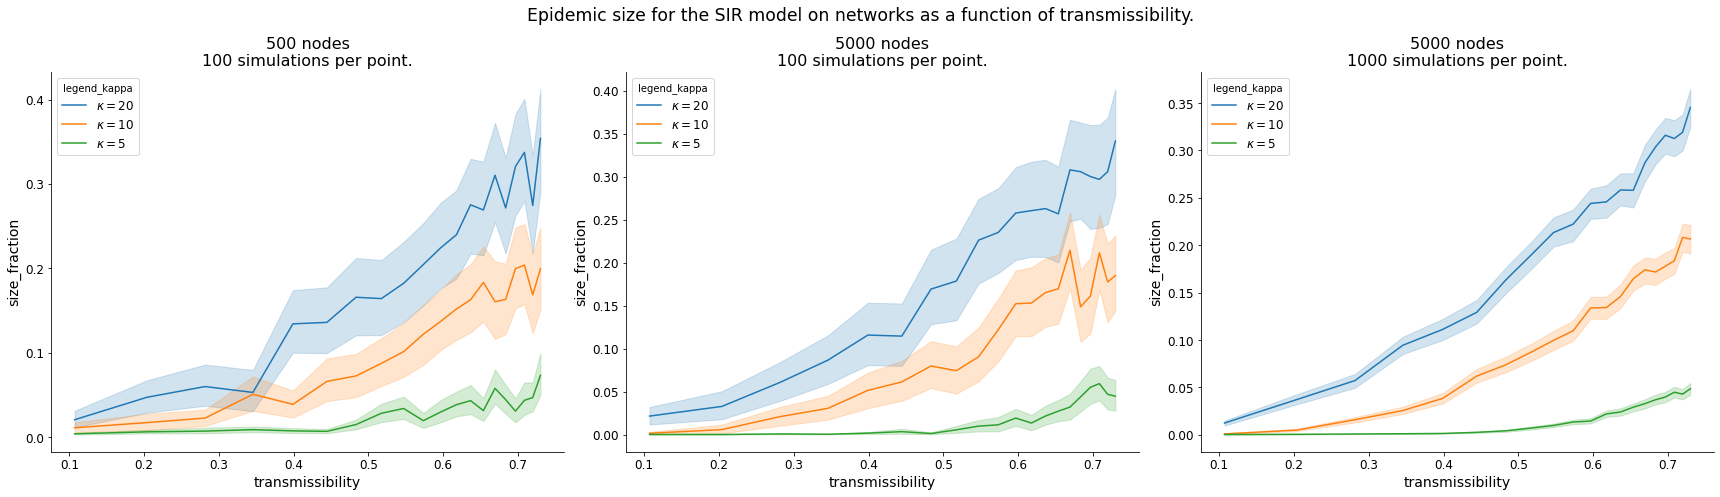

In [24]:
# load data
plague_100_500 = pd.read_csv('data/simulation.csv')
plague_100_5000 = pd.read_csv('data/simulation_100_5000.csv')
plague_1000_5000 = pd.read_csv('data/simulation_1000_5000.csv')
plague = [plague_100_500, plague_100_5000, plague_1000_5000]
nodes = [500, 5000, 5000]
sims = [100, 100, 1000]

# display figures using seaborn
fig, axx = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('Epidemic size for the SIR model on networks as a function of transmissibility.', fontsize = 'xx-large')
for data, ax, node, sim  in zip(plague, axx, nodes, sims) :
    ax.set_title(str(node) + ' nodes\n' + str(sim) + ' simulations per point.')
    sns.lineplot(data=data, x="transmissibility", y="size_fraction", hue="legend_kappa", ax=ax)
    
fig.tight_layout()

### <span style="color:darkcyan">Exercise 5.15
Approximately find the critical transmissibility $T_c$ for different values of $\kappa$ in yourr simulations, and compare your results to those of the manuscript. Are they similar? Since we are simulating a smaller system, we do not expect a perfect match, but we do expect a similar qualitative behaviouor.

*Your answer here*

### <span style="color:darkcyan">Exercise 5.16
Explain why $T_c$ decreases when $\kappa$ is increased. How is this related to the presence of super-spreaders, and how do they impact the global epidemic dynamics?